# Political Alignment Analysis in 140 Characters 
#### CX 4240, Spring 2019 
#### Jessica Buzzelli, Jarad Hosking, Aakanksha Patil 

# I: Problem

Twitter is a social media platform where users' status updates (tweets) can have the ability to impact how their followers percieve events, [especially in the realm of politics](https://www.nytimes.com/2019/04/11/us/politics/on-politics-twitter-democrats.html). In this project, we wanted to see how accuractely we could identify users' political affiliations, with the goal of making a model that could be applied to identify like-minded public figures to a given user.

Especially with [Twitter's ongoing decline in monthly users](https://www.bloomberg.com/news/articles/2018-07-27/twitter-projects-users-to-decline-profit-short-of-estimates), we hypothesize that such a tool could be used to further establish the site as a more specialized hub for political news and debate and, in turn, drive platform-unique content and reinvigorate overall site traffic. Another high potential use case could involve matching individuals with similarly-aligned local politicians in order to inspire more people to participate in non-federal elections.

# II: Approach

Our problem lies somewhere between a clustering and a classification problem:
1. Classification - we want a user's place on a political spectrum of some kind
1. Clustering - classification "labels" would be non-discrete, and
1. We wanted to project onto a meaningful space where we can bring prior knowledge on political parties, schools of thought into our interpretation of the data

Since we would have to reduce clustering dimensions in order to graph our results, we chose to treat the problem more like a classification and use ground-truth information on training users' (politicians) Nolan Charts from [OnTheIssues.org]() to solve for test users' placements.

Donald Trump translated as a Nolan point at (.8,.2):

<img src="report_imgs/donald_trump.gif" width="400"/>

# III: Dataset

Since Twitter frowns upon (but allows) its data being used to identify users based on federally protected classes such as political alignment, we have limited our test set of data to users whose public presences are based around their political commentary -- we refer to them collectively in this project as pundits.

Using a [Twitter API Python client](http://www.tweepy.org/) and an [SQLite](https://www.sqlite.org/index.html) database, we were able to save up to 3,200 tweets per user from this collection of politicians (training users) and pundits (testing users):

<img src="report_imgs/newflows.png" width="700"/>
<img src="report_imgs/flows22.png" width="700"/>

We were not able to obtain as many training users as ideal due to the manual nature of extracting ground-truth information and the lack of politicians with Twitter accounts active enough to have more than 2,000 tweets since the 2016 presidential election (a limit in case of changes in political affiliation or party policy over time). 

Finding pundits was simple, but we limited ourselves since we did not see an unbiased way to draw model conclusions for pundit users (no ground-truth scores available). Model accuracy is primarily derived from creating a testing split from training users.

__NOTE:__ We were unable to find any good examples of populists for our dataset, and therefore would ideally use [a different visualization convention](https://upload.wikimedia.org/wikipedia/commons/thumb/3/32/Political_Spectrum_Chart_NPOV.svg/380px-Political_Spectrum_Chart_NPOV.svg.png) if unbiased ground-truth data were similiarly available.

Before composing our feature matrix from the tweets in our database, we cleaned each tweet as follows:

<img src="report_imgs/preprocessing2.png" width="600"/>

After, we used [Term Frequency x Inverse Document Frequency (TF-IDF) scores](https://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html) trained on the politicians' combined corpus to build a feature matrix. 

We used this method in hopes of:
1. Excluding words not used by the polticians' accounts, and
1. Minimizing the weight of words that were rarely used by multiple politicans 

Our feature matricies had __378,013 training records__, __67,088 testing records__, __65,376 unique features__ (same number of features in training and testing matricies):

<img src="report_imgs/vecs2.png" width="550"/>

# IV: Results

### Attempt 1: Linear Regression + PCA

A [similiar problem](https://medium.com/linalgo/predict-political-bias-using-python-b8575eedef13) used logistic regression and clustering to predict the bias of newspaper headlines, but we used linear regression to get hard "classifications" of our training users' scores since we had access to ground-truth position data for our frame of reference.

With more features than records, we knew we would have to reduce our number of features. 

However, we saw two ways to continue:
1. Keep our feature matrix as-in and have each tweet be a data point
1. Reorganize our matrix to have each user's collection of tweets as a data point (__129 records__):
<img src="report_imgs/vecs1.png" width="700"/>

After finding ideal PCA component numbers for both setups, __the By-User matrix was the winner with an average error of 0.2403 units of distance on the Nolan Chart (the difference of roughly one quadrant) in a one-vs-rest cross-validation, and a standard deviation of 0.09 units.__ 

We suspect tweets' character limits result in a single tweet being a poor representation of an overall user. However, we would need more training users to fully validate this finding.

<img src="report_imgs/diff_matrix.png" width="1300"/>

We decided __75 PCA components__ was ideal for the By-User matrix via trial and error:
<img src="report_imgs/pca_comps2.png" width="700"/>

Our model's pundit estimations ("Failed" indicates model estimate >0.3 units from our personal estimates):

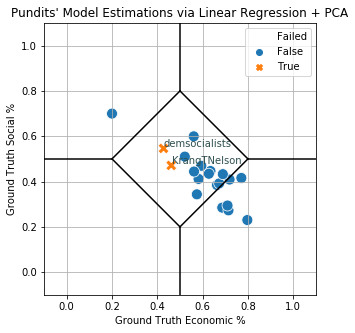

In [2]:
import linear_regression_model
%matplotlib inline
linear_regression_model.main(print_results=False)

Some examples using the linear regression models to suggest users to follow:

In [3]:
from linear_regression_model import getRecommendations

getRecommendations('Heritage') # Conservative-oriented publication -- recommendations are appropriate
getRecommendations('reason') # Right/Libertarian-oriented publication -- recommendations are appropriate
getRecommendations('lizmair') # Liz Mair, Libertarian campaign manager  -- recommendations are too liberal-focused
getRecommendations('KellyannePolls') # Kellyanne Conway, counselor to Pres. Trump -- recommendations are appropriate
getRecommendations('demsocialists') # Democratic Socialists of America's official Twitter -- inaccurate model placement

Hi nprpolitics! Based on your results, we recommend that you check out these Twitter users:
SarahPalinUSA, MichaelJohns, SenJohnMcCain, GovMikeHuckabee, SenScottBrown

Hi Heritage! Based on your results, we recommend that you check out these Twitter users:
GOPLeader, VP, JeffFlake, SenCoryGardner, SenSasse

Hi reason! Based on your results, we recommend that you check out these Twitter users:
EvanMcMullin, JohnKasich, lisamurkowski, sendavidperdue, SenDeanHeller

Hi lizmair! Based on your results, we recommend that you check out these Twitter users:
SenatorCollins, Hickenlooper, JulianCastro, SenatorHeitkamp, SenAngusKing

Hi KellyannePolls! Based on your results, we recommend that you check out these Twitter users:
realDonaldTrump, SenThadCochran, LindseyGrahamSC, EvanMcMullin, JohnKasich

Hi demsocialists! Based on your results, we recommend that you check out these Twitter users:
Sen_JoeManchin, SenDonnelly, SenatorHassan, Schwarzenegger, MarkWarner




### Attempt 2: Feature Engineering via Latent Dirichlet Allocation and Sentiment Data

Unlike [similar projects](https://medium.com/analytics-vidhya/twitter-sentiment-analysis-for-the-2019-election-8f7d52af1887) [using Twitter data for sentiment analysis](https://ieeexplore.ieee.org/document/6897213), we decided that a person's political affiliation is a combination of:

1. The topics they care about (or in this case, tweet about), and
1. Their sentiments (in this case, positive, negative, or neutral) towards those topics

Using [Vader sentiment analyser](https://www.nltk.org/_modules/nltk/sentiment/vader.html), we proceded as follows:

<img src="report_imgs/ldaflow.png" width="1000"/>


An example of the results we fed into a linear regression to get Nolan scores:

<img src="report_imgs/lda_sent_trump.png" width="700"/>

Of course, we also ran a "one vs. rest" cross validation on an LDA model that did not use the sentiment approach detailed above:

<img src="report_imgs/lda_comparisons2.png" width="1500"/>

Cross validation results of the sentiment-enabled model had a higher mean error and estimation variance than the linear regression model, so we consider this approach a dead-end in its current state.

__Our best LDA-based model used 8 topics had an average per-user error of .24 units and a standard deviation of .08 units. This performed about the same as the linear regression + PCA model.__

__NOTE:__ We used fewer components in LDA than PCA since LDA is a supervised method that strives to maximize class separability -- more LDA components would feed overfitting. 

Some training users' results from using linear regression on the sentiment-blind LDA output:
<img src="report_imgs/linreg_gif.gif" width="1500"/>

# V: Conclusion

Considerations:
* Our regression could possibly benefit from ensemble modeling using both of our feature matrix organizations; some left/liberal users had significantly better results with the By-Tweet feature matrix.

* We are skeptical about the scalability of the regression model in Attempt 1 due to our choice of the optimal number of PCA components selected being based on our current dataset.

* Regression to project users onto the chart was tricky since we lacked enough datapoints at the extremes of the chart to be able to place users towards the corners -- especially in the populists' quadrant.

* Sentiment data may have not been the most accurate given sarcasm, passive agressiveness aimed at other users, etc.; sentiment models have even higher variances than LDA, possibily due to our "one tweet = one topic" simplification or LDA's mutlivariate normal prior distribution.

* Topic-based models (Attempt 2) did not perform better when using Latent Semantic Analysis (LSA, or truncated SVD) -- they had extremely high average per-user errors and our efforts might have been misguided.

* A big concern for our approach is the possibility of users not tweeting as we would expect given a certain alignment, but we can only really counteract this by expanding our set of training users.